In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile 
import sqlite3
%matplotlib inline

import seaborn as sns

year_cutoff = 2000

In [2]:
#Load review info from Rotten Tomatoes
rt_review_df = pd.read_csv('../../data/rt.reviews.tsv.gz',delimiter='\t',encoding = 'unicode_escape')
rt_review_df['publisher'].fillna('N/A',inplace = True)

# Don't need written review. Date in this instance is review date and irrelevant
rt_review_df.drop(columns = ['review','date'], inplace = True)
rt_review_df['fresh_flag'] = (rt_review_df['fresh']=='fresh')

rt_review_df
rt_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   rating      40915 non-null  object
 2   fresh       54432 non-null  object
 3   critic      51710 non-null  object
 4   top_critic  54432 non-null  int64 
 5   publisher   54432 non-null  object
 6   fresh_flag  54432 non-null  bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 2.5+ MB


ID in this table is a unique movie identifier across rotten tomato datasets.

A movie can have multiple reviews. Therefore, we can get the 'Fresh' rating across all review and across all 'top critics' for every ID

In [3]:
#Paring the data down to only the 'top critics'
#This returns a series of tomato ratings as rated by top critics. Index by id
top_critic_reviews_sr = rt_review_df[rt_review_df['top_critic']==1].groupby('id').mean()['fresh_flag']

In [4]:
#This returns a series of tomato ratings as rated by all critics. Index by id
all_reviews_sr = rt_review_df.groupby('id').mean()['fresh_flag']

In [5]:
#Load movie info from Rotten Tomatoes
rt_movie_df = pd.read_csv('../../data/rt.movie_info.tsv.gz',delimiter = '\t')

# NOTE: No movie title provided in dataset. And unique identifier 'id' cannot be matched
# to another db.

#Create list of genres for each record
rt_movie_df['genre list'] = rt_movie_df['genre'].str.split('|')

# Convert runtime to numerical data
rt_movie_df['runtime_in_min'] = rt_movie_df['runtime'].map(lambda x: int(x[:-8]) if x is not np.nan else np.nan)

# Converting theater date to datetime object and creating year column
rt_movie_df['theater_date'] = pd.to_datetime(rt_movie_df['theater_date'])
rt_movie_df['year'] = rt_movie_df['theater_date'].dt.year

#'currency' and 'box_office' columns are about 4/5 empty. Dropping these columns. 
# Other datasets are morecomplete and this data can be gathered from there instead 
# Dropping synopsis and studio as well
rt_movie_df.drop(columns = ['synopsis','currency','box_office','studio','runtime'],inplace=True)


In [6]:
rt_movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1560 non-null   int64         
 1   rating          1557 non-null   object        
 2   genre           1552 non-null   object        
 3   director        1361 non-null   object        
 4   writer          1111 non-null   object        
 5   theater_date    1201 non-null   datetime64[ns]
 6   dvd_date        1201 non-null   object        
 7   genre list      1552 non-null   object        
 8   runtime_in_min  1530 non-null   float64       
 9   year            1201 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 122.0+ KB


Having calculated the 'Fresh' meter for each movie already we can create a column for each and add it to this master table

In [7]:
rt_movie_df['overall_tomato_rating'] = rt_movie_df['id'].map(lambda x: all_reviews_sr[x] if x in all_reviews_sr else np.nan)
rt_movie_df['top_critic_tomato_rating'] = rt_movie_df['id'].map(lambda x: top_critic_reviews_sr[x] if x in top_critic_reviews_sr else np.nan)

## Genre Performance
Drop every record with a na in genre
Create a boolean matrix for all different genres
Drop unneccessary columns

In [8]:
unique_genre_list = []
for genres in rt_movie_df['genre list'].dropna().tolist():
    for genre in genres:
        unique_genre_list.append(genre)
unique_genre_list =list(set(unique_genre_list))

In [9]:
rt_movie_genre_df = rt_movie_df[rt_movie_df['genre list'].notna()]


for genre in unique_genre_list:
    rt_movie_genre_df[genre] = rt_movie_genre_df['genre list'].map(lambda x: True if genre in x else False)


    


<ipython-input-9-000dca11f742>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rt_movie_genre_df[genre] = rt_movie_genre_df['genre list'].map(lambda x: True if genre in x else False)


In [10]:
# Get top 10 most released genres
rt_movie_genre_temp = rt_movie_genre_df[rt_movie_genre_df['year']>year_cutoff].drop(
    columns = ['rating','genre list','year','overall_tomato_rating','top_critic_tomato_rating',
               'id','genre','dvd_date','runtime_in_min'])
top_15_genres = list(rt_movie_genre_temp.sum().sort_values(ascending=False)[:15].index)


In [11]:
rt_movie_genre_temp.sum().sort_values(ascending=False)[:15]

Drama                          278
Comedy                         176
Action and Adventure           102
Mystery and Suspense            98
Art House and International     65
Romance                         57
Science Fiction and Fantasy     51
Horror                          40
Kids and Family                 35
Documentary                     28
Animation                       24
Special Interest                20
Musical and Performing Arts     19
Television                       8
Faith and Spirituality           7
dtype: int64

In [12]:
viz_data =[]
for genre in top_15_genres:
    grouped_df = rt_movie_genre_df[rt_movie_genre_df['year']>year_cutoff].groupby(genre).mean()
    viz_data.append([genre,grouped_df['overall_tomato_rating'][1],grouped_df['top_critic_tomato_rating'][1]]) 
viz_data.sort(key = lambda x: x[1],reverse = True)

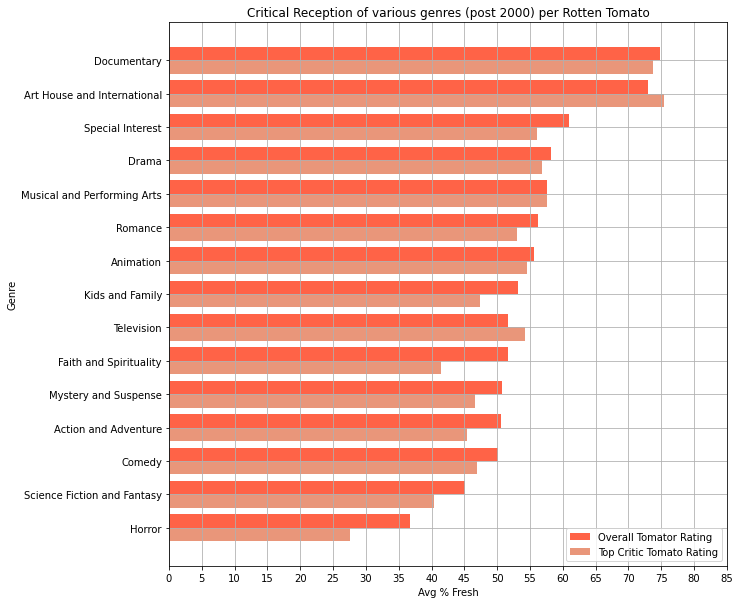

In [14]:
# Visualization
viz_labels = [v[0] for v in viz_data]
viz_all_ratings = [v[1]*100 for v in viz_data]
viz_top_ratings = [v[2]*100 for v in viz_data]

y = np.arange(len(viz_labels))
h = 0.6

fig, ax = plt.subplots(figsize=(10,10))


ax.grid()

ax.set_title(f'Critical Reception of various genres (post {year_cutoff}) per Rotten Tomato')
ax.set_ylabel('Genre')
ax.set_xlabel('Avg % Fresh')

ax.barh(y-h/3, viz_all_ratings, h/1.5,color='tomato')
ax.barh(y+h/3, viz_top_ratings, h/1.5,color='darksalmon')

ax.set_xticks(np.arange(0, 90, step=5))

ax.set_yticks(y)  
ax.set_yticklabels(labels=viz_labels)
ax.legend(['Overall Tomator Rating', 'Top Critic Tomato Rating'])
ax.invert_yaxis()

fig.savefig('../../images/PopularGenres_Critics.jpg',
            transparent = False,bbox_inches="tight");

## Runtime Performance

No corelation.

In [15]:
rt_runtime_df = rt_movie_df.dropna(subset=['runtime_in_min','overall_tomato_rating','top_critic_tomato_rating'])

Paring down runtime in min to the Inter quantile range

In [16]:
runtime_q3 = rt_runtime_df['runtime_in_min'].quantile(0.75)
runtime_q1 = rt_runtime_df['runtime_in_min'].quantile(0.25)
runtime_iqr = runtime_q3 - runtime_q1

In [17]:
(rt_runtime_df['runtime_in_min']>(runtime_q1 - 1.5*runtime_iqr)).describe()

count      880
unique       2
top       True
freq       879
Name: runtime_in_min, dtype: object

In [18]:
(rt_runtime_df['runtime_in_min']<(runtime_q3 + 1.5*runtime_iqr)).describe()

count      880
unique       2
top       True
freq       854
Name: runtime_in_min, dtype: object

In [19]:
rt_runtime_df = rt_runtime_df[(rt_runtime_df['runtime_in_min']>(runtime_q1 - 1.5*runtime_iqr)) & 
              (rt_runtime_df['runtime_in_min']<(runtime_q3 + 1.5*runtime_iqr))]

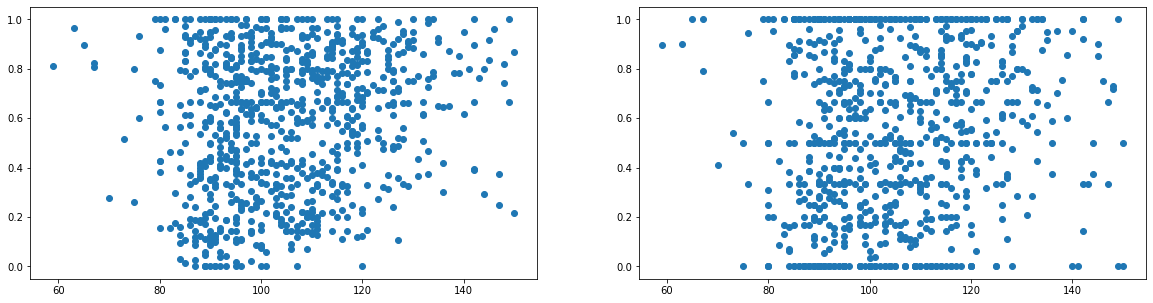

In [20]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].scatter(x= rt_runtime_df['runtime_in_min'],y = rt_runtime_df['overall_tomato_rating']);
ax[1].scatter(x= rt_runtime_df['runtime_in_min'],y = rt_runtime_df['top_critic_tomato_rating']);